## **1. Google Drive**

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
#%cd $cur_dir


In [2]:
#%pip install torchview


In [3]:
LOCAL = False


## **2. Import Libraries**

In [4]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'


# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu128
Device: cuda


## **3. Config**

In [5]:
USE_MASKED_PATCHES = False
SUB_MODEL = None

In [6]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches_blurred")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches_blurred")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")




TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches_blurred
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches_blurred


## **4. Train/Val Split**

In [7]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [8]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 2788 patches. Parsing metadata...
Successfully created DataFrame with 2788 rows.

First 5 rows:
          filename            label sample_id
0  img_0000_p0.png  Triple negative  img_0000
1  img_0000_p1.png  Triple negative  img_0000
2  img_0000_p2.png  Triple negative  img_0000
3  img_0000_p3.png  Triple negative  img_0000
4  img_0001_p0.png        Luminal B  img_0001

Patches per Bag (Distribution):
count    631.000000
mean       4.418384
std        2.771610
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [9]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [10]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2195
Val patches: 593

Train label distribution:
label
Luminal B          775
HER2(+)            607
Luminal A          602
Triple negative    211
Name: count, dtype: int64

Val label distribution:
label
Luminal B          189
Luminal A          168
HER2(+)            160
Triple negative     76
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          35.307517
HER2(+)            27.653759
Luminal A          27.425968
Triple negative     9.612756
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          31.871838
Luminal A          28.330523
HER2(+)            26.981450
Triple negative    12.816189
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [11]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    transforms.RandomErasing(
        p=0.3,  # Reduced probability for more balanced augmentation
        scale=(0.02, 0.15),  # Reduced max scale
        ratio=(0.3, 3.3)  # Aspect ratio range
    ),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

train_augmentation = transforms.Compose([
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),
    transforms.RandomHorizontalFlip(p=0.5)
])

## **6. Custom Dataset Class**

In [12]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None, normalize_imagenet=False, cache_images=True):
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet
        self.df = df
        
        # CRITICAL OPTIMIZATION: Pre-convert to lists
        self.paths = df['path'].tolist()
        self.labels = df['label_encoded'].tolist()
        
        # Define transforms
        self.to_tensor = transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])
        
        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None
        
        # For external use
        self.transform = transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) if normalize_imagenet else transforms.Identity()
        ])
        
        # --- IMAGE CACHING (Pre-load all images) ---
        self.image_cache = {}
        if cache_images:
            self._preload_images()
    
    def _preload_images(self):
        """Pre-load all images into memory for O(1) access during training."""
        total_images = len(self.paths)
        
        with tqdm(total=total_images, desc="Pre-loading images", unit="img") as pbar:
            for img_path in self.paths:
                if img_path not in self.image_cache:
                    try:
                        image = Image.open(img_path).convert("RGB")
                        image = self.to_tensor(image)
                        self.image_cache[img_path] = image
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        self.image_cache[img_path] = None
                
                pbar.update(1)
        
        print(f"Successfully cached {len(self.image_cache)} images.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        
        # Load image (from cache or disk)
        if img_path in self.image_cache:
            image = self.image_cache[img_path]
            if image is None:
                # Fallback for corrupted cached images
                image = torch.ones((3, TARGET_SIZE[0], TARGET_SIZE[1]), dtype=torch.float32) * 0.5
        else:
            # Fallback: Load on-the-fly if not cached
            try:
                img = Image.open(img_path).convert('RGB')
                image = self.to_tensor(img)
            except:
                image = torch.ones((3, TARGET_SIZE[0], TARGET_SIZE[1]), dtype=torch.float32) * 0.5
        
        # Apply augmentation
        if self.augmentation:
            image = self.augmentation(image)
        
        # Apply normalization
        if self.normalize:
            image = self.normalize(image)
        
        return image, label

## **7. Data Loaders**

In [13]:
if LOCAL: 
    num_workers = 0
    CACHE_IMAGES = False
else:
    num_workers = max(2, (os.cpu_count() or 2)//2)
    CACHE_IMAGES = True

# Instantiate Datasets
train_dataset = TissueDataset(
    df_train, 
    augmentation=train_augmentation, 
    normalize_imagenet=True,
    cache_images=CACHE_IMAGES  # Enable image pre-loading
)
val_dataset = TissueDataset(
    df_val, 
    augmentation=None, 
    normalize_imagenet=True,
    cache_images=CACHE_IMAGES  # Enable image pre-loading
)

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64



# Instantiate Loaders with optimizations
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True  # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True  # Keep workers alive between epochs
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Pre-loading images: 100%|██████████| 2195/2195 [00:43<00:00, 51.00img/s]


Successfully cached 2195 images.


Pre-loading images: 100%|██████████| 593/593 [00:11<00:00, 52.63img/s]

Successfully cached 593 images.
Train Loader: 35 batches
Val Loader: 10 batches
Num workers: 24



Visualizing Training Batch (Augmented):


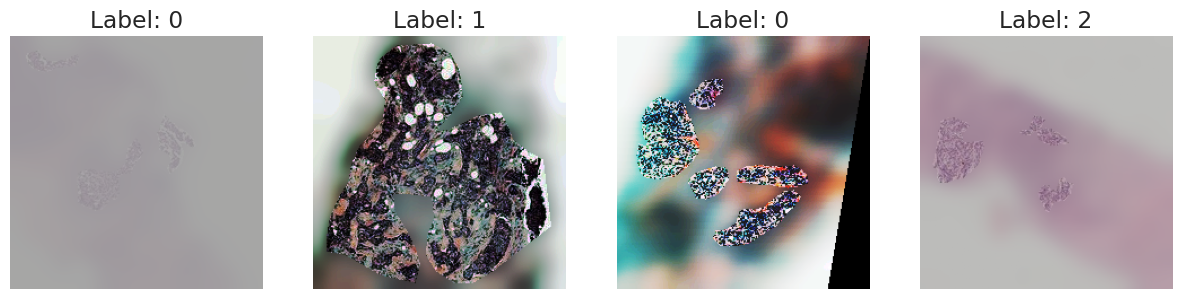

In [14]:
def show_batch(loader, count=4):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))

    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

    for i in range(count):
        ax = plt.subplot(1, count, i + 1)

        img = images[i]
        img = img * std + mean  # Un-normalize

        img = torch.clamp(img, 0, 1)  # Clip to valid range

        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader, 4)

## **8. Hyperparameters**

In [15]:
DROPOUT_RATE = 0.4
HIDDEN_SIZE = 512
L2_REG = 1e-4

NUM_EPOCHS = 1000  # Increased since we have early stopping
PATIENCE = 20    # Stop if val_loss doesn't improve for 5 epochs

## **9. Model Definition (Transfer Learning - MobileNetV3)**

In [16]:
import torch
import torch.nn as nn
import torchvision

class MobileNetV3Small(nn.Module):
    """MobileNetV3 Small architecture for image classification."""

    def __init__(self, num_classes, dropout_rate=0.2, freeze_backbone=True):
        super().__init__()
        self.freeze_backbone = freeze_backbone

        # Load MobileNetV3 Small with pretrained weights
        self.backbone = torchvision.models.mobilenet_v3_small(
            weights=torchvision.models.MobileNet_V3_Small_Weights.DEFAULT
        )

        # 1. FREEZE PARAMETERS (Weights/Biases)
        # This prevents the weights (gamma) and bias (beta) from changing.
        if self.freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False

        # MobileNetV3 classifier structure inputs
        # For MobileNetV3-Small, the last feature size is 576
        in_features = 576

        # Optimized Classifier Head
        self.backbone.classifier = nn.Sequential(
            # Layer 1: Expansion
            nn.Linear(in_features, 1024),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout_rate),

            # Layer 2: Bottleneck
            nn.Linear(1024, 128),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout_rate),

            # Layer 3: Final Classification 
            # If you need probabilities, add nn.Softmax(dim=1) after this.
            nn.Linear(128, num_classes) 
        )

    def forward(self, x):
        return self.backbone(x)

    def train(self, mode=True):
        """
        Override train mode to ensure frozen backbone BN layers 
        STAY in eval mode.
        """
        super().train(mode)

        # 2. FREEZE STATISTICS (Running Mean/Variance)
        # If we are freezing the backbone, we must ensure the BatchNorm layers
        # inside the backbone remain in eval mode, even when the rest of the 
        # model is training.
        if self.freeze_backbone and mode:
            for m in self.backbone.features.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.eval()
                    # Optional: Disable tracking purely for safety
                    m.track_running_stats = False

In [17]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = MobileNetV3Small(num_classes, DROPOUT_RATE, freeze_backbone=True)
model = model.to(device)

print(f"Model initialized (MobileNetV3Small) with {num_classes} output classes.")
#summary(model, input_size=(3, TARGET_SIZE[0], TARGET_SIZE[1]))

Model initialized (MobileNetV3Small) with 4 output classes.


## **10. Loss and Optimizer**

In [18]:
# 1. Get Counts (from your snippet)
class_counts = df_train['label_encoded'].value_counts().sort_index().values
total_samples = sum(class_counts)
n_classes = len(class_counts)

# 2. Define Manual Tuning Factors (The "weight" knob)
# 1.0 = Default (Pure Inverse Frequency)
# > 1.0 = Force model to focus MORE on this class (e.g., critical error)
# < 1.0 = Force model to focus LESS on this class (e.g., noisy label)
# Ensure this list length matches n_classes (4 in your case)
tuning_factors = torch.tensor([1.0, 0.8, 0.8, 0.6], dtype=torch.float32)

# 3. Calculate Base Weights (Standard Inverse Frequency)
# Formula: N / (C * freq)
base_weights = torch.tensor(
    [total_samples / (n_classes * c) for c in class_counts],
    dtype=torch.float32
)

# 4. Apply Tuning
# Final Weight = Inverse_Freq_Weight * Manual_Tuning_Factor
final_weights = base_weights * tuning_factors

# 5. Move to device
final_weights = final_weights.to(device)

print(f"Base Weights:  {base_weights}")
print(f"Tuning Factors:{tuning_factors}")
print(f"Final Weights: {final_weights}")

# Update Loss Function
criterion = nn.CrossEntropyLoss(weight=None, label_smoothing=0.2)

# Optimizer
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,
    # You can also include other Adam parameters like betas, eps, weight_decay
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)

# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3,
)

Base Weights:  tensor([0.9040, 0.9115, 0.7081, 2.6007])
Tuning Factors:tensor([1.0000, 0.8000, 0.8000, 0.6000])
Final Weights: tensor([0.9040, 0.7292, 0.5665, 1.5604], device='cuda:0')


## **11. Function: Training & Validation Loop**

In [19]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # Lists to store all predictions and labels for F1 calculation
    all_preds = []
    all_labels = []

    loop = tqdm(loader, leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics accumulation
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)

        # Move to CPU and convert to numpy for sklearn metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    # Calculate F1 Score (Macro for imbalanced data)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [20]:
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with MobileNetV3 (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion, device)

    # Update Scheduler (based on Loss) EXPERIMENT: No scheduler on TL
    #scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)


    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
        torch.save(model.state_dict(), 'models/best_model_mobilenetv3_tl.pt')
        model_saved = True
    else:
        model_saved = False
        patience_counter += 1



    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} Best:{best_val_f1:.4f} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break
    
SUB_MODEL = 'models/best_model_mobilenetv3_tl.pt'
print(f"Submodel saved to {SUB_MODEL} at epoch {best_tl_epoch} with Val F1: {best_val_f1:.4f} for now. Will update if better model found in fine tuning.")

Starting Training with MobileNetV3 (Patience: 20)...


TL Epoch 1/1000 | Loss: 1.3625 | F1: 0.1742 | Val Loss: 1.3576 | Val F1: 0.1208 | Patience: 0/20 Best:0.1208 ✓


TL Epoch 2/1000 | Loss: 1.3300 | F1: 0.1546 | Val Loss: 1.3530 | Val F1: 0.1994 | Patience: 0/20 Best:0.1994 ✓


TL Epoch 3/1000 | Loss: 1.3204 | F1: 0.2802 | Val Loss: 1.3554 | Val F1: 0.1805 | Patience: 1/20


TL Epoch 4/1000 | Loss: 1.3147 | F1: 0.2631 | Val Loss: 1.3430 | Val F1: 0.2692 | Patience: 0/20 Best:0.2692 ✓


TL Epoch 5/1000 | Loss: 1.3063 | F1: 0.2866 | Val Loss: 1.3458 | Val F1: 0.2478 | Patience: 1/20


TL Epoch 6/1000 | Loss: 1.3085 | F1: 0.3147 | Val Loss: 1.3350 | Val F1: 0.2715 | Patience: 0/20 Best:0.2715 ✓


TL Epoch 7/1000 | Loss: 1.3042 | F1: 0.3092 | Val Loss: 1.3384 | Val F1: 0.2503 | Patience: 1/20


TL Epoch 8/1000 | Loss: 1.2993 | F1: 0.3370 | Val Loss: 1.3405 | Val F1: 0.2512 | Patience: 2/20


TL Epoch 9/1000 | Loss: 1.2961 | F1: 0.3204 | Val Loss: 1.3324 | Val F1: 0.2956 | Patience: 0/20 Best:0.2956 ✓


TL Epoch 10/1000 | Loss: 1.2973 | F1: 0.3349 | Val Loss: 1.3371 | Val F1: 0.2809 | Patience: 1/20


TL Epoch 11/1000 | Loss: 1.2936 | F1: 0.3469 | Val Loss: 1.3399 | Val F1: 0.2599 | Patience: 2/20


TL Epoch 12/1000 | Loss: 1.2921 | F1: 0.3498 | Val Loss: 1.3564 | Val F1: 0.2265 | Patience: 3/20


TL Epoch 13/1000 | Loss: 1.2844 | F1: 0.3624 | Val Loss: 1.3385 | Val F1: 0.3116 | Patience: 0/20 Best:0.3116 ✓


TL Epoch 14/1000 | Loss: 1.2755 | F1: 0.3628 | Val Loss: 1.3385 | Val F1: 0.3039 | Patience: 1/20


TL Epoch 15/1000 | Loss: 1.2855 | F1: 0.3814 | Val Loss: 1.3457 | Val F1: 0.2160 | Patience: 2/20


TL Epoch 16/1000 | Loss: 1.2792 | F1: 0.3643 | Val Loss: 1.3325 | Val F1: 0.3087 | Patience: 3/20


TL Epoch 17/1000 | Loss: 1.2876 | F1: 0.3780 | Val Loss: 1.3434 | Val F1: 0.2984 | Patience: 4/20


TL Epoch 18/1000 | Loss: 1.2873 | F1: 0.3434 | Val Loss: 1.3591 | Val F1: 0.2667 | Patience: 5/20


TL Epoch 19/1000 | Loss: 1.2830 | F1: 0.3737 | Val Loss: 1.3578 | Val F1: 0.2811 | Patience: 6/20


TL Epoch 20/1000 | Loss: 1.2696 | F1: 0.3938 | Val Loss: 1.3481 | Val F1: 0.2736 | Patience: 7/20


TL Epoch 21/1000 | Loss: 1.2767 | F1: 0.3680 | Val Loss: 1.3526 | Val F1: 0.3023 | Patience: 8/20


TL Epoch 22/1000 | Loss: 1.2699 | F1: 0.3926 | Val Loss: 1.3690 | Val F1: 0.2227 | Patience: 9/20


TL Epoch 23/1000 | Loss: 1.2692 | F1: 0.3912 | Val Loss: 1.3534 | Val F1: 0.2339 | Patience: 10/20


TL Epoch 24/1000 | Loss: 1.2591 | F1: 0.3954 | Val Loss: 1.3398 | Val F1: 0.3449 | Patience: 0/20 Best:0.3449 ✓


TL Epoch 25/1000 | Loss: 1.2713 | F1: 0.3733 | Val Loss: 1.3411 | Val F1: 0.3002 | Patience: 1/20


TL Epoch 26/1000 | Loss: 1.2634 | F1: 0.3969 | Val Loss: 1.3566 | Val F1: 0.2272 | Patience: 2/20


TL Epoch 27/1000 | Loss: 1.2644 | F1: 0.4246 | Val Loss: 1.3468 | Val F1: 0.2509 | Patience: 3/20


TL Epoch 28/1000 | Loss: 1.2637 | F1: 0.4016 | Val Loss: 1.3508 | Val F1: 0.2237 | Patience: 4/20


TL Epoch 29/1000 | Loss: 1.2686 | F1: 0.3965 | Val Loss: 1.3713 | Val F1: 0.2072 | Patience: 5/20


TL Epoch 30/1000 | Loss: 1.2618 | F1: 0.3996 | Val Loss: 1.3653 | Val F1: 0.2510 | Patience: 6/20


TL Epoch 31/1000 | Loss: 1.2649 | F1: 0.4259 | Val Loss: 1.3383 | Val F1: 0.3007 | Patience: 7/20


TL Epoch 32/1000 | Loss: 1.2671 | F1: 0.3825 | Val Loss: 1.3403 | Val F1: 0.2964 | Patience: 8/20


TL Epoch 33/1000 | Loss: 1.2581 | F1: 0.4222 | Val Loss: 1.3483 | Val F1: 0.3051 | Patience: 9/20


TL Epoch 34/1000 | Loss: 1.2606 | F1: 0.4144 | Val Loss: 1.3673 | Val F1: 0.2562 | Patience: 10/20


TL Epoch 35/1000 | Loss: 1.2489 | F1: 0.4298 | Val Loss: 1.3836 | Val F1: 0.2308 | Patience: 11/20


TL Epoch 36/1000 | Loss: 1.2532 | F1: 0.4226 | Val Loss: 1.3892 | Val F1: 0.1897 | Patience: 12/20


TL Epoch 37/1000 | Loss: 1.2492 | F1: 0.4308 | Val Loss: 1.3600 | Val F1: 0.3396 | Patience: 13/20


TL Epoch 38/1000 | Loss: 1.2516 | F1: 0.4306 | Val Loss: 1.3514 | Val F1: 0.2988 | Patience: 14/20


TL Epoch 39/1000 | Loss: 1.2465 | F1: 0.4248 | Val Loss: 1.3605 | Val F1: 0.3130 | Patience: 15/20


TL Epoch 40/1000 | Loss: 1.2588 | F1: 0.4221 | Val Loss: 1.3665 | Val F1: 0.2219 | Patience: 16/20


TL Epoch 41/1000 | Loss: 1.2466 | F1: 0.4344 | Val Loss: 1.3450 | Val F1: 0.2916 | Patience: 17/20


TL Epoch 42/1000 | Loss: 1.2508 | F1: 0.4097 | Val Loss: 1.3479 | Val F1: 0.2663 | Patience: 18/20


TL Epoch 43/1000 | Loss: 1.2489 | F1: 0.4350 | Val Loss: 1.3705 | Val F1: 0.2743 | Patience: 19/20


TL Epoch 44/1000 | Loss: 1.2427 | F1: 0.4320 | Val Loss: 1.3867 | Val F1: 0.1835 | Patience: 20/20
   >>> Early Stopping Triggered! Training stopped.
Submodel saved to models/best_model_mobilenetv3_tl.pt at epoch 24 with Val F1: 0.3449 for now. Will update if better model found in fine tuning.


### 12.2 Training History

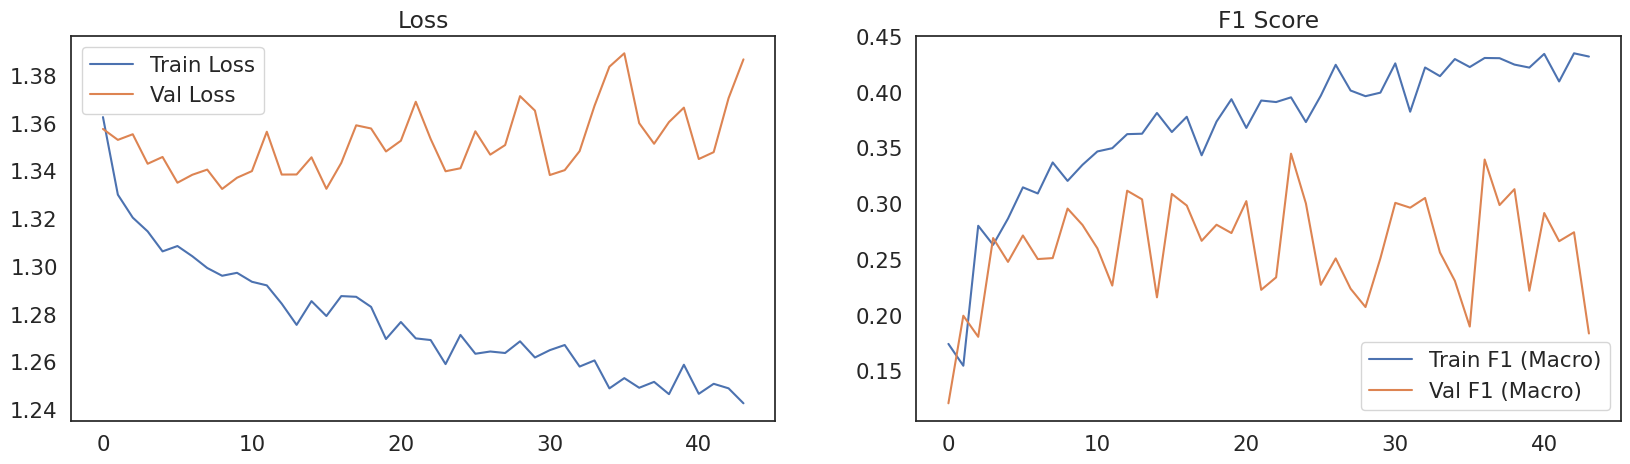

Best Validation F1 Score: 0.3449 at epoch 24


In [21]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.3 Function: Generate Predictions

In [22]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level.
    Strategy: Average the Softmax probabilities of all patches in a bag.
    """
    model.eval()

    # Access the dataframe from the dataset
    dataset = loader.dataset
    df = dataset.df
    
    # Define the inference transform explicitly to match Validation logic
    # (Resize -> ToTensor -> Normalize)
    inference_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    y_true = []
    y_pred = []

    # Get unique sample IDs (original images)
    sample_ids = df['sample_id'].unique()

    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches belonging to this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth (all patches share the image label)
        # We use the column name you stored in dataset.label_col (default 'label_encoded')
        true_label = sample_patches.iloc[0]['label_encoded'] 
        y_true.append(true_label)

        # Load and process all patches for this image
        patches = []
        for img_path in sample_patches['path']:
            try:
                # Load image (ensure RGB)
                img = Image.open(img_path).convert('RGB')
                
                # Apply the manual inference transform
                img = inference_transform(img)
                
                patches.append(img)
            except Exception as e:
                continue

        if not patches:
            y_pred.append(true_label) # Fallback
            continue

        # Stack patches into a single batch: [Num_Patches, 3, 224, 224]
        batch = torch.stack(patches).to(device)

        with torch.no_grad():

            logits  = model(batch) 
            
            probs = torch.softmax(logits, dim=1)

            # --- Aggregation: Mean Probability ---
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred

### 12.4 Confusion Matrix

In [24]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()


Generating Confusion Matrix on Original Images...

Aggregating predictions for 127 unique images...


KeyboardInterrupt: 

In [ ]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """Plot all patches of a single sample and the aggregated image prediction."""
    import math
    model.eval()
    dataset = loader.dataset
    df = dataset.df

    # Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # Load and transform all patches
    images_tensors = []
    display_imgs = []
    for _, row in sample_patches.iterrows():
        img = Image.open(row['path']).convert('RGB')
        if dataset.transform:
            tensor_img = dataset.transform(img)
        else:
            tensor_img = transforms.ToTensor()(img)
        images_tensors.append(tensor_img)
        # denormalize for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        display_imgs.append(torch.clamp(tensor_img * std + mean, 0, 1))

    batch = torch.stack(images_tensors).to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1).cpu()

    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    if aggregation_method == 'max_confidence':
        # Average probabilities (Soft Voting)
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        # Hard Voting
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        # Normalize counts for visualization purposes
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label = label_encoder.inverse_transform([sample_patches.iloc[0]['label_encoded']])[0]

    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        lbl = label_encoder.inverse_transform([pred])[0]
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9)
        ax.axis('off')

    # Aggregated distribution
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'steelblue' for i in range(len(class_names))]
    ax_bar.barh(class_names, image_probs, color=colors)
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label} | Pred: {image_pred_label} ({image_conf:.2%})\nMethod: {aggregation_method}")
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a random validation sample
print("Plotting random validation sample with prediction distribution:")
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence')

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [ ]:
# 1. Initialize the NEW model instance
#    (Make sure to use the same class definition you used for training)
ft_model = MobileNetV3Small(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# 2. Load the best weights from the first phase
ft_model.load_state_dict(torch.load("models/best_model_mobilenetv3_tl.pt"), strict=True)

# 3. Unfreeze parameters
#    First, ensure everything is frozen
for param in ft_model.parameters():
    param.requires_grad = False

#    Unfreeze the Classifier (Head)
for param in ft_model.backbone.classifier.parameters():
    param.requires_grad = True

#    Unfreeze the last 2 blocks of the Backbone (Features)
#    EfficientNet B0 features are in 'ft_model.backbone.features'
for block in ft_model.backbone.features[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# Optimizer
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=1e-4,
    # You can also include other Adam parameters like betas, eps, weight_decay
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=L2_REG
)

# 5. New Scheduler for the new optimizer
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3,
)

print("Starting Fine-Tuning")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1_ft = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
ft_better_than_tl = False
# Training Loop using ft_model and ft_optimizer
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion, ft_optimizer, device)

    # Validate
    val_loss, val_f1 = validate(ft_model, val_loader, criterion, device)

    # Update Scheduler
    ft_scheduler.step(val_loss)

    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)



    # --- Checkpointing (Save Best Model based on F1) --- and Early Stopping
    if val_f1 > best_val_f1_ft:
        best_val_f1_ft = val_f1
        best_ft_epoch = epoch + 1
        patience_counter_ft = 0  # Reset counter
        torch.save(ft_model.state_dict(), 'models/best_model_mobilenetv3_ft.pt')
        model_saved = True
        if best_val_f1_ft > best_val_f1:
            ft_better_than_tl = True
    else:
        model_saved = False
        patience_counter_ft += 1

    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE}")
    if patience_counter_ft >= PATIENCE:
        print("Early Stopping Triggered! Best FT Epoch: {} with Val F1: {:.4f}".format(best_ft_epoch, best_val_f1_ft))
        break



In [ ]:
if ft_better_than_tl:
    print("Fine-Tuning improved over Transfer Learning. Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1_ft, best_ft_epoch))
    SUB_MODEL = 'models/best_model_mobilenetv3_ft.pt'
else:
    print("Fine-Tuning did not improve over Transfer Learning. Best Validation F1 Score remains: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))
    SUB_MODEL = 'models/best_model_mobilenetv3_tl.pt'

### 13.2 Training History

In [ ]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

In [ ]:

# 1. Get predictions for the Transfer Learning model (from original `model`)
print("Generating Confusion Matrix for Transfer Learning Model...")
y_true_tl, y_pred_tl = get_image_predictions(model, val_loader, device)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

# 2. Get predictions for the Fine-Tuning model (from `ft_model`)
print("Generating Confusion Matrix for Fine-Tuning Model...")
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

# 3. Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Transfer Learning)')

# Plot Fine-Tuning Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Fine-Tuning)')

plt.tight_layout()
plt.show()


In [ ]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Class Activation Maps**

### **14.1 Cam Helper Functions**

In [ ]:
# --- 1. Grad-CAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Hooks
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)
            
        # Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        # Generate CAM
        gradients = self.gradients
        activations = self.activations
        b, k, u, v = gradients.size()
        
        # Global Average Pooling
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)
        
        # Linear combination
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) 
        
        # Normalize
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, u, v)
        
        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Mask Overlay Function ---
def get_mask_overlay(cam_mask, patch_path, masks_dir, img_fallback=None, alpha=0.6):
    """
    Overlays a Class Activation Map (CAM) onto the ground truth mask.
    Returns: (overlay_image, mask_found_boolean)
    """
    bg_img = None
    mask_found = False

    if masks_dir:
        # Derive mask filename: img_xxxx.png -> mask_xxxx.png
        filename = os.path.basename(patch_path)
        mask_filename = filename.replace('img_', 'mask_')
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            try:
                mask_pil = Image.open(mask_path).convert('L') 
                mask_pil = mask_pil.resize((224, 224))
                mask_np = np.array(mask_pil)
                # Normalize and convert to RGB
                mask_display = mask_np.astype(np.float32) / 255.0 
                bg_img = np.stack([mask_display]*3, axis=-1)
                mask_found = True
            except Exception as e:
                print(f"Error loading mask {mask_filename}: {e}")

    # Fallback Logic
    if bg_img is None:
        if img_fallback is not None:
            bg_img = img_fallback
        else:
            bg_img = np.zeros((224, 224, 3), dtype=np.float32)

    # Process Heatmap
    heatmap = cv2.resize(cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255

    # Overlay
    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_img)
    overlay = overlay / np.max(overlay) 
    
    return overlay, mask_found

# --- 3. Main Visualization Function ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, masks_dir=None):
    """
    Visualizes analysis for a sample. 
    Row 1: [Original], [CAM on Img], [CAM on Mask (HIDDEN if missing)], [Stats]
    Row 2: Other Classes CAMs (Fallback to Image if Mask missing)
    """
    model.eval()
    
    # Setup
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found.")
        return

    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # Inference
    patch_probs = []
    patch_images = []
    
    target_layer = model.backbone.features[-1]
    grad_cam = GradCAM(model, target_layer)
    
    print(f"Processing sample {sample_id}...")
    
    for _, row in sample_rows.iterrows():
        img_pil = Image.open(row['path']).convert('RGB')
        img_tensor = transform_pipeline(img_pil).unsqueeze(0).to(device)
        patch_images.append({'tensor': img_tensor, 'path': row['path']})
        
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            patch_probs.append(probs.cpu().numpy())

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0) 
    
    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    true_label = sample_rows.iloc[0]['label']
    
    # Best patch
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_patch_data = patch_images[best_patch_idx]
    img_tensor_active = best_patch_data['tensor'].clone().detach().requires_grad_(True)
    patch_path = best_patch_data['path']

    # 1. Background Image
    img_display = inv_normalize(best_patch_data['tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    # 2. Predicted Class CAMs
    pred_cam_mask, _ = grad_cam(img_tensor_active, pred_class_idx)
    
    # A: Overlay on Image
    heatmap = cv2.resize(pred_cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    cam_on_image = (0.5 * heatmap_colored) + (0.5 * img_display)
    cam_on_image = cam_on_image / np.max(cam_on_image)
    
    # B: Overlay on Mask (Row 1, Col 3)
    cam_on_mask_main, mask_found_main = get_mask_overlay(
        pred_cam_mask, patch_path, masks_dir, img_fallback=img_display
    )

    # 3. Other Classes CAMs (Row 2)
    cam_others_data = {}
    for i in range(len(classes)):
        if i == pred_class_idx: continue
        mask, _ = grad_cam(img_tensor_active, i)
        
        # We allow fallback here so we can still see activations for other classes
        overlay, is_mask = get_mask_overlay(
            mask, patch_path, masks_dir, img_fallback=img_display
        )
        cam_others_data[i] = (overlay, is_mask)
        
    grad_cam.remove_hooks() 

    # --- Plotting ---
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]
    
    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices)), height_ratios=[1.2, 0.8])

    # Row 1
    # 1. Original
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Most Representative Patch\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Predicted CAM on Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus on Image: {pred_label}\n(Score: {avg_probs[pred_class_idx]:.2f})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')
    
    # 3. Predicted CAM on Mask (Conditional)
    ax2 = plt.subplot(gs[0, 2])
    if mask_found_main:
        ax2.imshow(cam_on_mask_main)
        ax2.set_title(f"Focus on Mask: {pred_label}\n(Ground Truth Overlay)", fontsize=12, fontweight='bold')
        ax2.axis('off')
    else:
        # Deactivate subplot if mask is missing (avoid redundancy with ax1)
        ax2.set_visible(False)

    # 4. Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'
    
    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Bag Prediction Probabilities\nSample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', linestyle='--', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Row 2: Other Classes on MASK (with fallback)
    for idx, class_idx in enumerate(other_indices):
        ax = plt.subplot(gs[1, idx])
        overlay, is_mask = cam_others_data[class_idx]
        
        ax.imshow(overlay)
        class_name = classes[class_idx]
        bg_type = "Mask" if is_mask else "Img"
        ax.set_title(f"Activ. on {bg_type}: {class_name}\n(Score: {avg_probs[class_idx]:.2f})", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### **14.2 CAM Visualization**

In [ ]:
# Select a sample ID from your validation set
if SUB_MODEL is None:
    SUB_MODEL = 'models/best_model_mobilenetv3_tl.pt'  # Default to TL model if none specified
PATCH_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results","train_patches","masks")
cam_model = MobileNetV3Small(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)
cam_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
cam_idx = random.randint(0, len(df_val['sample_id'].unique()) - 1)
sample_id_to_test = df_val['sample_id'].iloc[cam_idx] 
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device)
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device, masks_dir=PATCH_MASKS_DIR)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [ ]:
sub_model = MobileNetV3Small(num_classes, DROPOUT_RATE, freeze_backbone=True).to(device)

# 2. Load the best weights from the training
sub_model.load_state_dict(torch.load(SUB_MODEL), strict=True)



### 14.2 Define Transform

In [ ]:
val_transform = transforms.Compose([
    # No augmentation for validation, just resizing and normalization
    transforms.Resize(TARGET_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

### 14.3 Function: Submission CSV

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import numpy as np

def generate_submission(model, submission_folder, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file by predicting on patches and aggregating results.

    Args:
        model: Trained PyTorch model.
        submission_folder: Path to folder containing test patches.
        method: 'majority_voting' or 'max_confidence'.
        output_csv: Filename for the output CSV.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    print(f"Aggregation Method: {method}")

    # Store predictions per image
    # Structure: { 'img_0001': {'votes': [], 'probs': []}, ... }
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # Extract Sample ID (e.g., "img_0015_p12.png" -> "img_0015")
                # Adjust split logic if your naming convention is different
                sample_id = filename.rsplit('_p', 1)[0]

                # Initialize dictionary for this sample if new
                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # Load and Transform
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # Predict
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)

                # Store probabilities for this patch
                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) # Shape: [Num_Patches, Num_Classes]

        # Ensure sample_index has .png extension as requested
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) # Default fallback
            continue

        if method == 'majority_voting':
            # Get class prediction for each patch
            patch_preds = np.argmax(all_probs, axis=1)
            # Find most frequent class
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            # Option A: Average probabilities (Soft Voting) - usually best/safest
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

            # Option B: Strict Max Confidence (Uncomment if you prefer this)
            # max_probs = np.max(all_probs, axis=0)
            # final_class_idx = np.argmax(max_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Create Pandas DataFrame and Save
    df_submission = pd.DataFrame(final_results)

    # Ensure correct column order
    df_submission = df_submission[['sample_index', 'label']]

    # Sort by sample_index for neatness
    df_submission.sort_values('sample_index', inplace=True)

    # Save to CSV
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    print(df_submission.head())

    return df_submission



### 14.3 Create the Submission CSV

In [ ]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:


now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")